# Explanatory Anomaly Detection on Nuscenes data

This system demos the reasonableness monitoring system and anomaly detection through explanations on the Nuscenes dataset.  This code assumes that the database is available at `../data/`, but this can be changed to the directory where the dataset is located.  

This is processing on the mini version of the full dataset.  The full dataset processing will soon follow.  

In [1]:
%matplotlib inline
from nuscenes.nuscenes import NuScenes
import pprint as pp
from nuscenes.utils.data_classes import *

# TODO: this should be changed somewhere 
data_root = '/Users/leilani/Dropbox (MIT)/car-can-explain/data/'
nuscenes_root = data_root+'nuscenes-data/'
data_name = 'v1.0-mini'

nusc = NuScenes(version=data_name, dataroot=nuscenes_root+data_name, verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 1.6 seconds.
Reverse indexing ...
Done reverse indexing in 0.7 seconds.


# Dataset Scrambling to Invoke Errors

Start with one scene at a time. Split into 50% normal, 50% not normal.  

In [2]:
!python3 scramble.py -v -n 18358

INFO: Verbose output.
DEBUG: probability is set to 0.500000
DEBUG: [1 0 1 ... 1 0 1]
DEBUG: Reasonable Count: 9291
DEBUG: Uneasonable Count: 9067
DEBUG: Reasonable Percentage: 0.506101
DEBUG: Unreasonable Percentage: 0.493899


In [8]:
nusc.list_categories()

Category stats for split v1.0-mini:
human.pedestrian.adult      n= 4765, width= 0.68±0.11, len= 0.73±0.17, height= 1.76±0.12, lw_aspect= 1.08±0.23
human.pedestrian.child      n=   46, width= 0.46±0.08, len= 0.45±0.09, height= 1.37±0.06, lw_aspect= 0.97±0.05
human.pedestrian.constructi n=  193, width= 0.69±0.07, len= 0.74±0.12, height= 1.78±0.05, lw_aspect= 1.07±0.16
human.pedestrian.personal_m n=   25, width= 0.83±0.00, len= 1.28±0.00, height= 1.87±0.00, lw_aspect= 1.55±0.00
human.pedestrian.police_off n=   11, width= 0.59±0.00, len= 0.47±0.00, height= 1.81±0.00, lw_aspect= 0.80±0.00
movable_object.barrier      n= 2323, width= 2.32±0.49, len= 0.61±0.11, height= 1.06±0.10, lw_aspect= 0.28±0.09
movable_object.debris       n=   13, width= 0.43±0.00, len= 1.43±0.00, height= 0.46±0.00, lw_aspect= 3.35±0.00
movable_object.pushable_pul n=   82, width= 0.51±0.06, len= 0.79±0.10, height= 1.04±0.20, lw_aspect= 1.55±0.18
movable_object.trafficcone  n= 1378, width= 0.47±0.14, len= 0.45±0.07, heigh

# Task 1: Single Frame Scramble 
For a single scene, get a frame, generate the scramble flags.   

In [3]:
import datetime
import scramble
import numpy as np
import utils
# import os
# import sys
# sys.path.insert(0, os.path.abspath('.'))

# help(scramble)
# dir(scramble)

In [12]:
first_scene = nusc.scene[0]
first_token = first_scene['first_sample_token']
first_frame = nusc.get('sample', first_token)

# def iterate_scenes(limit=1, debug=False):
#     """
#     This will go through all the scenes in a particular dataset.
#     Currently limit is set to 1 for testing.
    
#     Assumes that scenes are independent (instances are not tracked across scenes)
#     """
#     for index in range(0,limit):
#         if debug:
#             print("Processing Scene %d"%index)
#         check_scene(nusc.scene[index], debug)
def categoryDistribution():
    """ 
    Gets the categories, counts and stats. These stats only cover the split specified in nusc.version. 
    Help from list_categorie: used for dataset scrambling
    """
    # Add all annotations
    categories = dict()
    total_annotations = 0
    for record in nusc.sample_annotation:
        if record['category_name'] not in categories:
            categories[record['category_name']] = []
        categories[record['category_name']].append(record['size'] + [record['size'][1] / record['size'][0]])
        total_annotations+=1

    category_stats = dict()
    category_devs = dict()
    for name, stats in sorted(categories.items()):
        stats = np.array(stats)
        category_stats[name] = stats.shape[0]/total_annotations
        category_devs[name] = [np.std(stats[:,0]), np.std(stats[:,1]), np.std(stats[:,2])]
#             print('{:27} n={:5}, width={:5.2f}\u00B1{:.2f}, len={:5.2f}\u00B1{:.2f}, height={:5.2f}\u00B1{:.2f}, '
#                   'lw_aspect={:5.2f}\u00B1{:.2f}'.format(name[:27], stats.shape[0],
#                                                          np.mean(stats[:, 0]), np.std(stats[:, 0]),
#                                                          np.mean(stats[:, 1]), np.std(stats[:, 1]),
#                                                          np.mean(stats[:, 2]), np.std(stats[:, 2]),
#                                                          np.mean(stats[:, 3]), np.std(stats[:, 3])))
    keys, values = zip(*category_stats.items())
    return (keys, values)

def scrambleFrame(frame, candidates, distributions, debug=False):
    """
    Go through all the annotations for a particular frame
    """
    TOTAL_ANNS = len(frame['anns'])
    
    if debug:
        print("Frame at %s has %d labeled objects" %(utils.convert_time(frame['timestamp']), TOTAL_ANNS))
    
    flags=scramble.scrambleFlags(len(frame['anns']), .5)
    scrambled_anns = dict()

    i = 0
    for ann_token in frame['anns']:
        ann_data = nusc.get('sample_annotation', ann_token)
        if flags[i]:
            new_label = scramble.chooseNewLabel(ann_data['category_name'], candidates, distributions)
            scrambled_anns[ann_token] = (ann_data['category_name'], new_label)
            
            #print(ann_data['category_name'], "will be scrambled to", new_label)
        i+=1
        
    if debug:
        scramble.printDistribution(.5, flags)
        print("------------")
        for annotation in scrambled_anns:
            (old, new) = scrambled_anns[annotation]
            print(old, "will be scrambled to", new)
            
        #instance = ann_data['instance_token']
    
def scrambleScene(scene, debug):
    return

(candidates, probs) = categoryDistribution()
scrambleFrame(first_frame, candidates, probs)

# Testing that the driver code runs.

The driver currently runs the uber example and searches through a commonsense knowledge base (ConceptNet) with verbose messages .  

In [15]:
!python3 driver.py -v 

INFO: Verbose output.
INFO: Explaining behavior in the vehicle domain

DEBUG: commonsense/relations.csv is parsed as a csv file
DEBUG:    Relation URI  ...                       Examples
0  ------------  ...                       --------
1  /r/RelatedTo  ...              learn ↔ erudition
2     /r/FormOf  ...                  slept → sleep
3        /r/IsA  ...  car → vehicle; Chicago → city
4     /r/PartOf  ...                gearshift → car

[5 rows x 3 columns]
DEBUG: commonsense/anchors.csv is parsed as a csv file
DEBUG:    Relation URI  ...                       Examples
0  ------------  ...                       --------
1  /r/RelatedTo  ...              learn ↔ erudition
2     /r/FormOf  ...                  slept → sleep
3        /r/IsA  ...  car → vehicle; Chicago → city
4     /r/PartOf  ...                gearshift → car

[5 rows x 3 columns]
SHOULDN'T HAVE
DEBUG: searching for an anchor point for unknown_object
DEBUG: anchor point object is partof the concept phrase: unknown

## A Gentle Introduction to nuScenes (from tutorial)

Here are the top-down introduction of our database. This section is an elaboration of `schema.md`. The dataset comprises of elemental building blocks that are the following:

1. `scene` - 20 second snippet of a car's journey.
2. `sample` - An annotated snapshot of a scene at a particular timestamp.
3. `sample_data` - Data collected from a particular sensor.
4. `sample_annotation` - An annotated instance of an object within our interest.
5. `instance` - Enumeration of all object instance we observed.
6. `category` - Taxonomy of object categories (e.g. vehicle, human). 
7. `attribute` - Property of an instance that can change while the category remains the same.
8. `visibility` - Fraction of pixels visible in all the images collected from 6 different cameras.. 
9. `sensor` - A specific sensor type.
10. `calibrated sensor` - Definition of a particular sensor as calibrated on a particular vehicle.
11. `ego_pose` - Ego vehicle poses at a particular timestamp.
12. `log` - Log information from which the data was extracted.
13. `map` - Map data that is stored as binary semantic masks from a top-down view.

### 1. `scene`

nuScenes is a large scale database that features annotated samples across ***1000 scenes*** of approximately 20 seconds each. Let's take a look at the scenes that we have in the loaded database.

In [2]:
nusc.list_scenes()

scene-0061, Parked truck, construction, intersectio... [18-07-24 03:28:47]   19s, singapore-onenorth, #anns:4622
scene-0103, Many peds right, wait for turning car, ... [18-08-01 19:26:43]   19s, boston-seaport, #anns:2046
scene-0655, Parking lot, parked cars, jaywalker, be... [18-08-27 15:51:32]   20s, boston-seaport, #anns:2332
scene-0553, Wait at intersection, bicycle, large tr... [18-08-28 20:48:16]   20s, boston-seaport, #anns:1950
scene-0757, Arrive at busy intersection, bus, wait ... [18-08-30 19:25:08]   20s, boston-seaport, #anns:592
scene-0796, Scooter, peds on sidewalk, bus, cars, t... [18-10-02 02:52:24]   20s, singapore-queensto, #anns:708
scene-0916, Parking lot, bicycle rack, parked bicyc... [18-10-08 07:37:13]   20s, singapore-queensto, #anns:2387
scene-1077, Night, big street, bus stop, high speed... [18-11-21 11:39:27]   20s, singapore-hollandv, #anns:890
scene-1094, Night, after rain, many peds, PMD, ped ... [18-11-21 11:47:27]   19s, singapore-hollandv, #anns:1762
sc

Let's look at a scene metadata

In [5]:
first_scene = nusc.scene[0]
fourth_scene = nusc.scene[4]
first_scene

def get_description(scene):
    """
    Returns a list of the descriptions of a particular scene
    Underscores make it easier to query the commonsense knowledge base
    """
    text_description = scene['description']
    descriptions = text_description.split(',')
    description_list = []
    for label in descriptions:
        # for conceptNet debugging
        description_list.append(label.strip().replace(' ', '_').lower())
    return description_list

print(get_description(first_scene))
print(get_description(fourth_scene))

['parked_truck', 'construction', 'intersection', 'turn_left', 'following_a_van']
['arrive_at_busy_intersection', 'bus', 'wait_at_intersection', 'bicycle', 'peds']


### Nuscenes Analysis and Testing

In [6]:
import datetime
NORMALIZE = 1000000.0

def iterate_scenes(limit=1, debug=False):
    """
    This will go through all the scenes in a particular dataset.
    Currently limit is set to 1 for testing.
    
    Assumes that scenes are independent (instances are not tracked across scenes)
    """
    for index in range(0,limit):
        if debug:
            print("Processing Scene %d"%index)
        explain_scene(nusc.scene[index], debug)

def explain_scene(scene, debug=False):
    raw_data = {}
    first_token = scene['first_sample_token']
    frame = nusc.get('sample', first_token)
    time = convert_time(frame['timestamp'])
    sizes = []
    
    frame_tokens = [first_token]
    
    while frame['next']: # is not None:
        token = frame['next']
        #print("getting data for %s"%token)
        frame = nusc.get('sample', token)
        populate_frame_data(frame, time, raw_data, sizes, debug) # This updates the raw_data 
        time = convert_time(frame['timestamp'])
        frame_tokens.append(token)
    #print("Finished explaining scene at time=%d seconds with %s"%(time, scene['token'], scene['description']))
    if debug:
        print("Finished explaining scene at %s with %s"%(time, scene['description']))
        print("Summary of explanations at scene level with %d distinct annotations"%len(raw_data))

def populate_frame_data(frame, time, raw_data, sizes, debug=False):
    """
    Go through all the annotations for a particular frame
    """
    if debug:
        print("Frame at %s has %d labeled objects" %( convert_time(frame['timestamp']), len(frame['anns'])))
    
    #raw_data = {}
    for ann_token in frame['anns']:
        ann_data = nusc.get('sample_annotation', ann_token)
        instance = ann_data['instance_token']
        # Need category, size, translation
        # Might also what to store keys
        # Split into LiDAR and Vision 
        
        # token, sample_token, instance_token, visibility_token, if attribute_tokens
        # translation, size, prev and next --> Which ones are they referring to
        frame_explanation = monitor_frame(ann_data, sizes)
        results = (ann_data, frame_explanation)
        if instance not in raw_data:
            raw_data[instance] = [results]
        else:
            raw_data[instance].append(results)
        #raw_data.append([ann_data['category_name'], ann_data['visibility_token'], ann_data['translation'], ann_data['size']])
    #print(raw_data)
    #track_annotation(ann_data['instance_token'], ann_data['next'])

keys = ['visibility_token', 'size', 'translation', 'category_name']
    
def monitor_frame(ann_data, size):
    #print(ann_data)
    #print({k:d[k] for k in l if k in d})
    #print({k:ann_data[k] for k in ann_data if k in keys})
    # Convert translation / size to feet and take away ego pose.
    return

def track_annotation(instance_token, next_token):
    instance = nusc.get('instance', instance_token)
    #print(instance)
    annotation = nusc.get('sample_annotation', next_token)
    #print("In tracking and annotation is %s" %annotation)
    describe(annotation, nusc.get('sample', annotation['sample_token']))
    
    while not annotation['next'] == '':
        next_annotation = nusc.get('sample_annotation', annotation['next'])
        # print(next_annotation)
        annotation = next_annotation
        describe(annotation, nusc.get('sample', annotation['sample_token']))
    print("Done processing annotation")
    return

def convert_time(unix_time):
    return datetime.datetime.fromtimestamp(unix_time/NORMALIZE)

def describe(annotation, sample):
    print("%s found at time %s"%(annotation['category_name'], convert_time(sample['timestamp'])))

explain_scene(first_scene, True) # Debugging is on for now

Frame at 2018-07-23 23:28:48.147847 has 78 labeled objects
Frame at 2018-07-23 23:28:48.698048 has 86 labeled objects
Frame at 2018-07-23 23:28:49.197353 has 94 labeled objects
Frame at 2018-07-23 23:28:49.697797 has 103 labeled objects
Frame at 2018-07-23 23:28:50.152601 has 103 labeled objects
Frame at 2018-07-23 23:28:50.648325 has 110 labeled objects
Frame at 2018-07-23 23:28:51.198511 has 118 labeled objects
Frame at 2018-07-23 23:28:51.697833 has 120 labeled objects
Frame at 2018-07-23 23:28:52.197715 has 124 labeled objects
Frame at 2018-07-23 23:28:52.647284 has 127 labeled objects
Frame at 2018-07-23 23:28:53.146604 has 129 labeled objects
Frame at 2018-07-23 23:28:53.646462 has 136 labeled objects
Frame at 2018-07-23 23:28:54.146351 has 137 labeled objects
Frame at 2018-07-23 23:28:54.696555 has 141 labeled objects
Frame at 2018-07-23 23:28:55.197541 has 143 labeled objects
Frame at 2018-07-23 23:28:55.697945 has 147 labeled objects
Frame at 2018-07-23 23:28:56.198962 has 148

This sample has 69 labeled objects
human.pedestrian.adult
[1224.59321504, 3708.7238719600005, 2.6246720000000003]
Visibility: {'description': 'visibility of whole object is between 0 and 40%', 'token': '1', 'level': 'v0-40'}
Global translation is [373.256, 1130.419, 0.8]
somewhat close
To the right
 
human.pedestrian.adult
[1243.0709059199999, 3783.95025232, 2.8379266]
Visibility: {'description': 'visibility of whole object is between 40 and 60%', 'token': '2', 'level': 'v40-60'}
Global translation is [378.888, 1153.348, 0.865]
somewhat close
To the right
 
vehicle.car
[1160.74150696, 3715.0755782, 1.97506568]
Visibility: {'description': 'visibility of whole object is between 60 and 80%', 'token': '3', 'level': 'v60-80'}
Global translation is [353.794, 1132.355, 0.602]
somewhat close
To the right
 
human.pedestrian.adult
[1234.0223492, 3800.87610588, 3.07742792]
Visibility: {'description': 'visibility of whole object is between 80 and 100%', 'token': '4', 'level': 'v80-100'}
Global tra

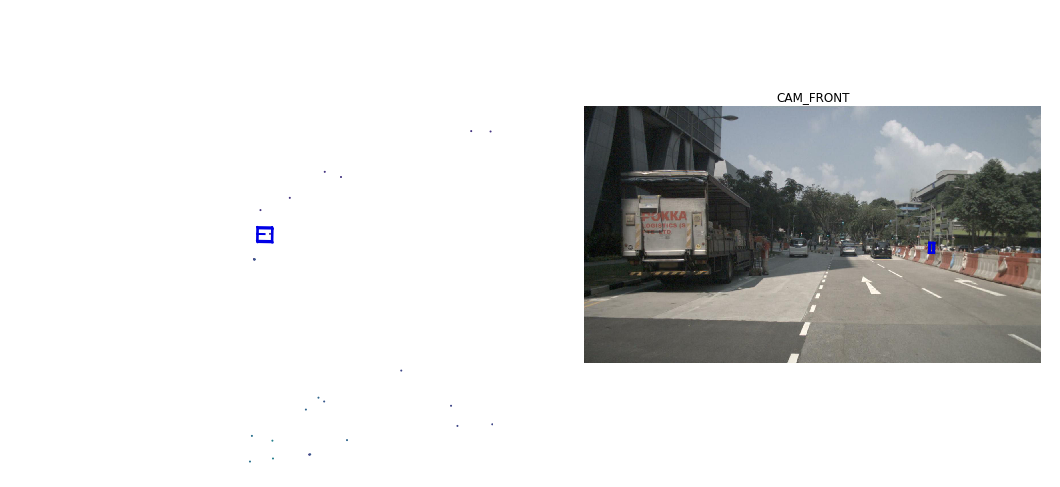

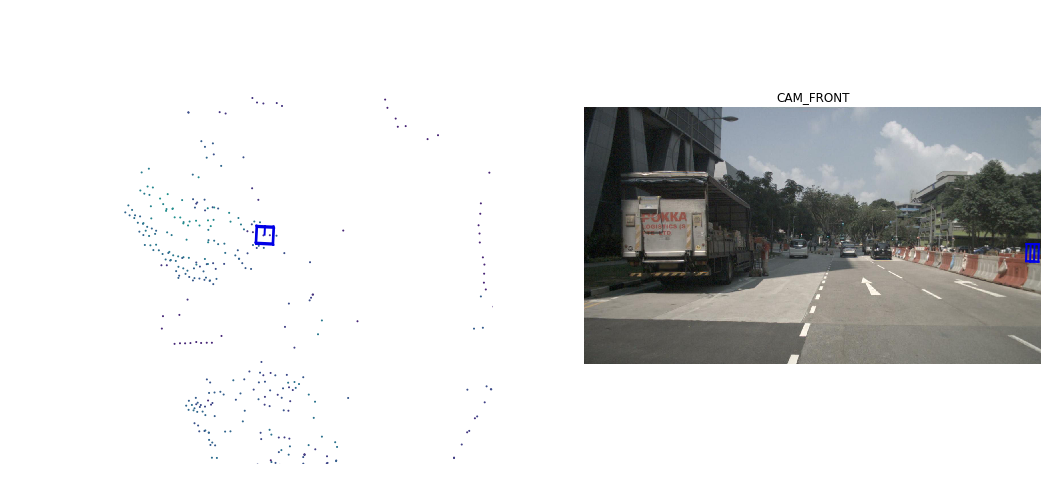

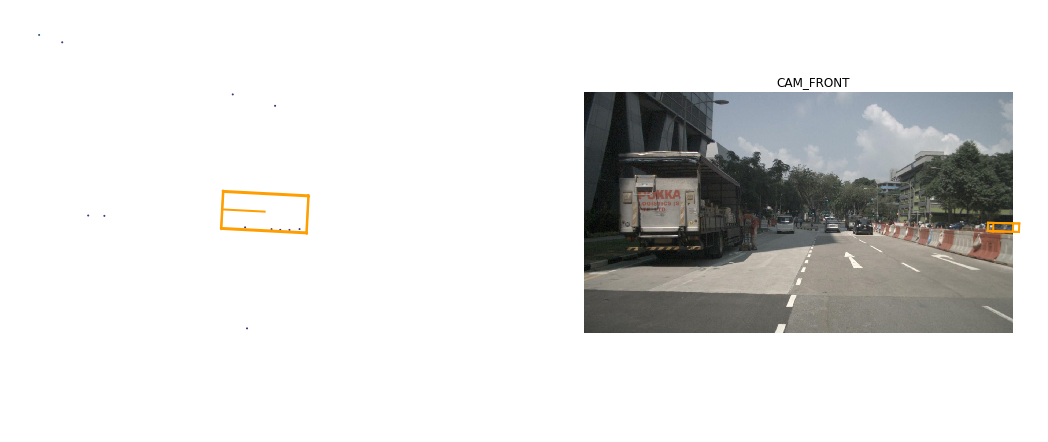

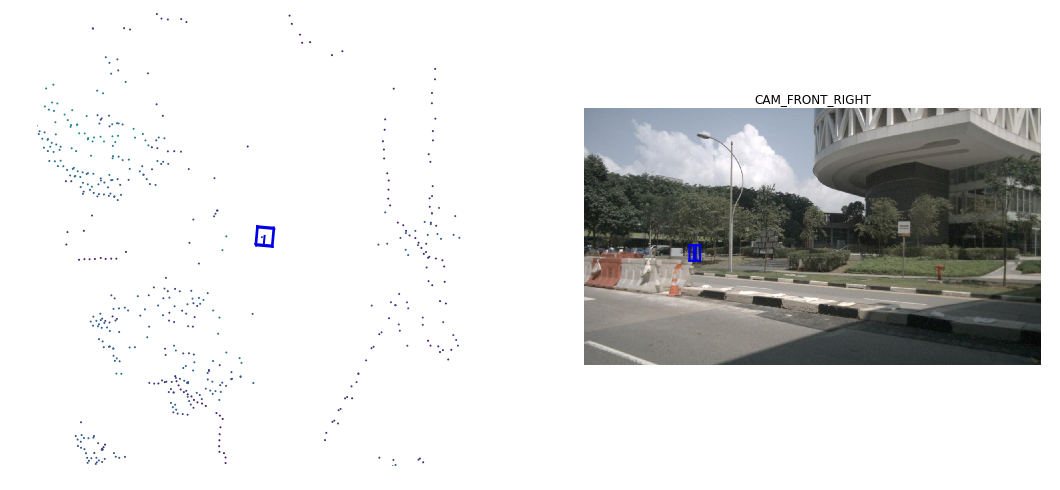

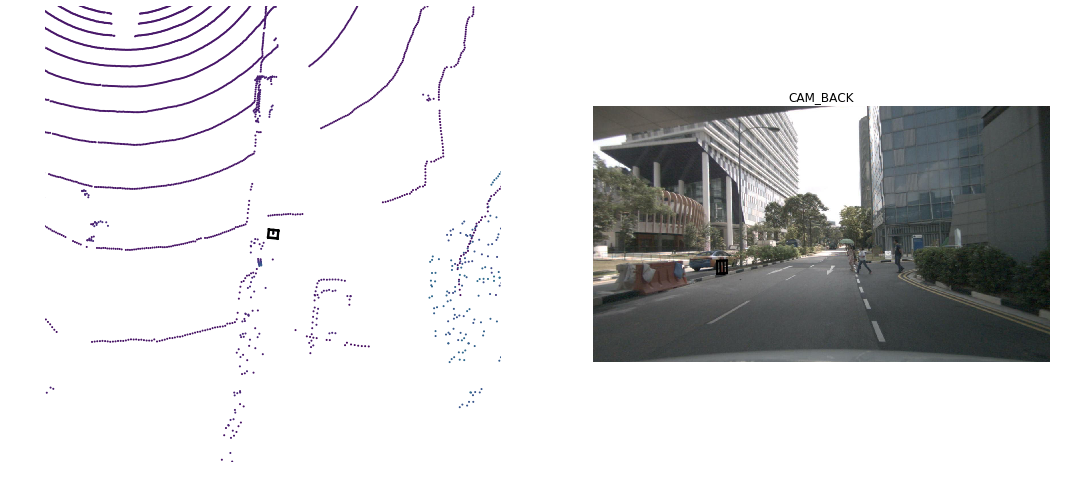

In [49]:
intersection_scene = nusc.scene[3]
frame_annotations = first_frame['anns']

camera = 'CAM_FRONT'
front_camera_data = nusc.get('sample_data', first_frame['data'][camera])
pose = nusc.get('ego_pose', front_camera_data['ego_pose_token'])
car_pose = pose['translation']
label_name = 'category_name'


print("This sample has %d labeled objects" % len(frame_annotations))
smaller_annotations = frame_annotations[0:5]
feet_per_meter = 3.28084

def localize(pose, translation):
    [base_x, base_y, base_z] = pose
    [t_x, t_y, t_z] = translation
    diff = [base_x-t_x, base_y-t_y, base_z-t_z]
    return [x * feet_per_meter for x in diff]

def qualitative_translation(location):
    [center_x, center_y, center_z] = location
    qualities = []
    if center_y >= 1000:
        qualitites.append("far-away")
        print("Far away")
    elif center_y <= 10: 
        qualities.append("closer")
        print("closer")
    elif center_y > 0: 
        qualities.append("closer")
        print("somewhat close")
    else:
        qualities.append("behind")
        print("behind")
    
    if center_x >= 0:
        qualities.append("right")
        print("To the right")
    else:
        qualities.append("left")
        print("to the left")
    return qualities

def sample_label(anntoken):
    meta = nusc.get('sample_annotation', anntoken)
    label = meta[label_name]
    print(label)
    print( [element * feet_per_meter for element in meta['translation']])
    visibility_token = meta['visibility_token']
    print("Visibility: {}".format(nusc.get('visibility', visibility_token)))
    #Estimated bounding box location in m in the global frame: center_x, center_y, center_z
    
    #Every sample_data has a record on which sensor the data is collected from (note the "channel" key)

    global_obj = meta['translation']
    #print(first_frame)
    print("Global translation is %s"%meta['translation'])
    qualitative_translation(localize(car_pose, meta['translation']))
    print(" ")
    nusc.render_annotation(anntoken)
    #time.sleep(5)

for anntoken in smaller_annotations: #sample['anns']:
    sample_label(anntoken)

In [7]:
total_scenes = len(nusc.scene)
total_scenes

for item in nusc.scene:
    print(get_description(item))


['parked_truck', 'construction', 'intersection', 'turn_left', 'following_a_van']
['many_peds_right', 'wait_for_turning_car', 'long_bike_rack_left', 'cyclist']
['wait_at_intersection', 'bicycle', 'large_truck', 'peds_crossing_crosswalk', 'ped_with_stroller']
['parking_lot', 'parked_cars', 'jaywalker', 'bendy_bus', 'gardening_vehicles']
['arrive_at_busy_intersection', 'bus', 'wait_at_intersection', 'bicycle', 'peds']
['scooter', 'peds_on_sidewalk', 'bus', 'cars', 'truck', 'fake_construction_worker', 'bicycle', 'cross_intersection', 'car_overtaking_us']
['parking_lot', 'bicycle_rack', 'parked_bicycles', 'bus', 'many_peds', 'parked_scooters', 'parked_motorcycle']
['night', 'big_street', 'bus_stop', 'high_speed', 'construction_vehicle']
['night', 'after_rain', 'many_peds', 'pmd', 'ped_with_bag', 'jaywalker', 'truck', 'scooter']
['night', 'peds_in_sidewalk', 'peds_cross_crosswalk', 'scooter', 'pmd', 'difficult_lighting']


### 2. `sample` or `frames`
(We refer to these as frames)

Scenes are annotated every half a second (2 Hz).

Each `sample` is an ***annotated keyframe of a scene at a given timestamp***. A keyframe is a frame where the time-stamps of data from all the sensors should be very close to the time-stamp of the sample it points to.

Below is a trial:

In [2]:
first_scene = nusc.scene[0]
first_frame_token = first_scene['first_sample_token']

# The rendering command below is commented out because it tends to crash in notebooks
# nusc.render_sample(first_sample_token)

Let's examine its metadata

In [4]:
first_frame = nusc.get('sample', first_frame_token)

first_frame

{'token': 'ca9a282c9e77460f8360f564131a8af5',
 'timestamp': 1532402927647951,
 'prev': '',
 'next': '39586f9d59004284a7114a68825e8eec',
 'scene_token': 'cc8c0bf57f984915a77078b10eb33198',
 'data': {'RADAR_FRONT': '37091c75b9704e0daa829ba56dfa0906',
  'RADAR_FRONT_LEFT': '11946c1461d14016a322916157da3c7d',
  'RADAR_FRONT_RIGHT': '491209956ee3435a9ec173dad3aaf58b',
  'RADAR_BACK_LEFT': '312aa38d0e3e4f01b3124c523e6f9776',
  'RADAR_BACK_RIGHT': '07b30d5eb6104e79be58eadf94382bc1',
  'LIDAR_TOP': '9d9bf11fb0e144c8b446d54a8a00184f',
  'CAM_FRONT': 'e3d495d4ac534d54b321f50006683844',
  'CAM_FRONT_RIGHT': 'aac7867ebf4f446395d29fbd60b63b3b',
  'CAM_BACK_RIGHT': '79dbb4460a6b40f49f9c150cb118247e',
  'CAM_BACK': '03bea5763f0f4722933508d5999c5fd8',
  'CAM_BACK_LEFT': '43893a033f9c46d4a51b5e08a67a1eb7',
  'CAM_FRONT_LEFT': 'fe5422747a7d4268a4b07fc396707b23'},
 'anns': ['ef63a697930c4b20a6b9791f423351da',
  '6b89da9bf1f84fd6a5fbe1c3b236f809',
  '924ee6ac1fed440a9d9e3720aac635a0',
  '91e3608f55174a319

### 3. `sample_data`

The nuScenes dataset contains data that is collected from a full sensor suite. Hence, for each snapshot of a scene, we provide references to a family of data that is collected from these sensors. 

We provide a `data` key to access these:

{'token': 'e3d495d4ac534d54b321f50006683844', 'sample_token': 'ca9a282c9e77460f8360f564131a8af5', 'ego_pose_token': 'e3d495d4ac534d54b321f50006683844', 'calibrated_sensor_token': '1d31c729b073425e8e0202c5c6e66ee1', 'timestamp': 1532402927612460, 'fileformat': 'jpg', 'is_key_frame': True, 'height': 900, 'width': 1600, 'filename': 'samples/CAM_FRONT/n015-2018-07-24-11-22-45+0800__CAM_FRONT__1532402927612460.jpg', 'prev': '', 'next': '68e8e98cf7b0487baa139df808641db7', 'sensor_modality': 'camera', 'channel': 'CAM_FRONT'}


{'token': 'e3d495d4ac534d54b321f50006683844',
 'timestamp': 1532402927612460,
 'rotation': [0.5720063498929273,
  -0.0021434844534272707,
  0.011564094980151613,
  -0.8201648693182716],
 'translation': [411.4199861830012, 1181.197175631848, 0.0]}

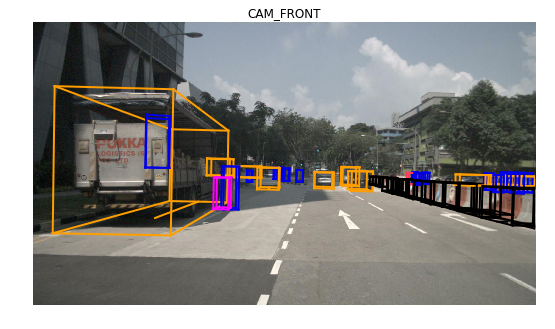

In [118]:
camera = 'CAM_FRONT'

def get_sample_vision_data(sample):
    return nusc.get('sample_data', sample['data'][camera])
print(get_sample_vision_data(first_frame))

# Renders that specific frame/sample data
front_camera_data = nusc.get('sample_data', first_frame['data'][camera])
nusc.render_sample_data(front_camera_data['token'])
ego_token = front_camera_data['ego_pose_token']

pose = nusc.get('ego_pose', front_camera_data['ego_pose_token'])
pose

### 4. `sample_annotation`

`sample_annotation` refers to any ***bounding box defining the position of an object seen in a sample***. All location data is given with respect to the global coordinate system. Let's examine an example from our `sample` above.

vehicle.car
[6.597769240000001, 15.20013172, 5.16076132]
Visibility: {'description': 'visibility of whole object is between 60 and 80%', 'token': '3', 'level': 'v60-80'}
Translation is [353.794, 1132.355, 0.602]
quaterion is [0.9797276292877292, 0.0, 0.0, -0.20033415188191459]

human.pedestrian.adult
[2.46719168, 2.68700796, 5.37073508]
Visibility: {'description': 'visibility of whole object is between 80 and 100%', 'token': '4', 'level': 'v80-100'}
Translation is [376.13, 1158.507, 0.938]
quaterion is [0.8444541532778473, 0.0, 0.0, 0.5356278400268174]



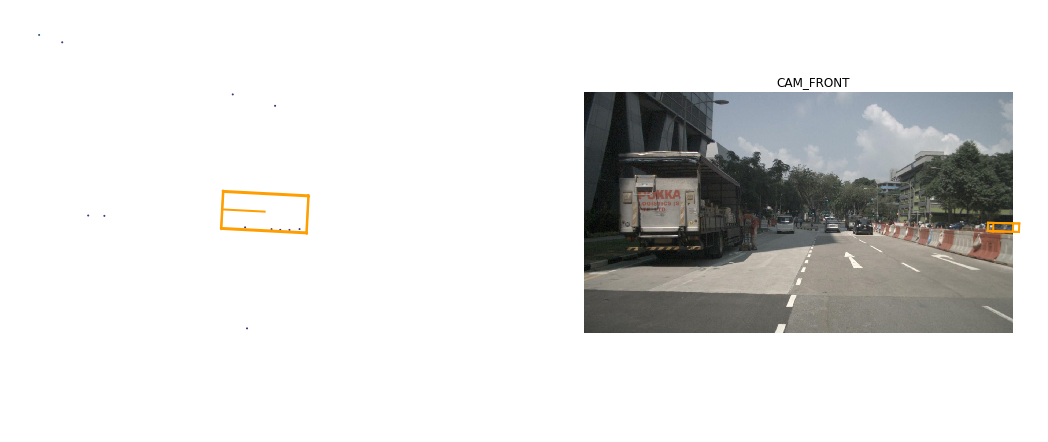

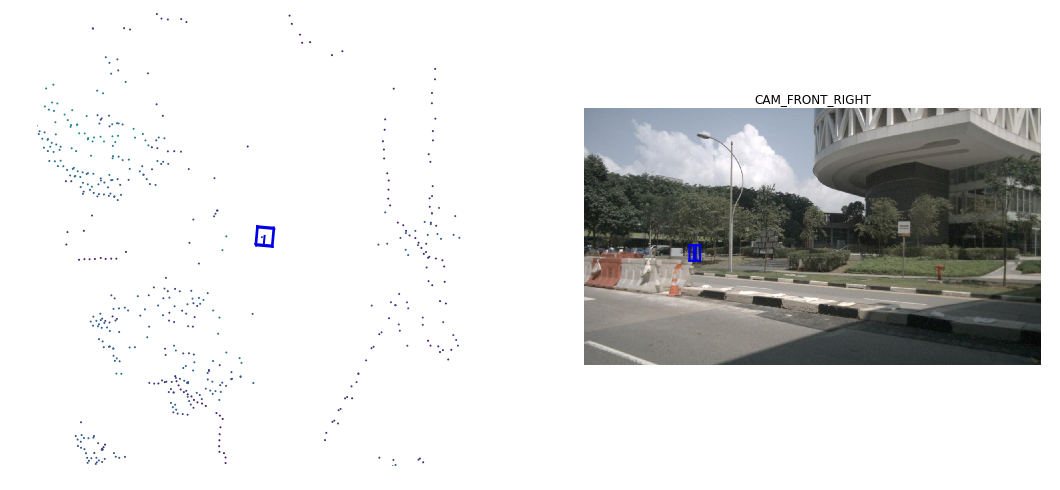

In [139]:
import time
import pprint as pp
from pyquaternion import Quaternion
import numpy as np
# For this exercise, setting first_sample to frane

first_sample = first_frame
label_name = 'category_name'
meters_to_feet = 3.28084

my_annotation_token = first_sample['anns'][1]
first_sample

# print("The first sample has %d labeled objects" % len(first_sample['anns']))
smaller_annotations = first_sample['anns'][0:4]
# print("The smaller sample has %d labeled objects" % len(smaller_annotations))

my_annotation_metadata =  nusc.get('sample_annotation', my_annotation_token)
# my_annotation_metadata

def iterate_sample_labels(sample, debug=False):
    smaller_annotations = sample['anns'][2:4]
    for anntoken in smaller_annotations: #sample['anns']:
        sample_label(anntoken)
        
def sample_label(anntoken):
    meta = nusc.get('sample_annotation', anntoken)
    label = meta[label_name]
    print(label)
    print( [element * meters_to_feet for element in meta['size']])
    visibility_token = meta['visibility_token']
    print("Visibility: {}".format(nusc.get('visibility', visibility_token)))
    #Estimated bounding box location in m in the global frame: center_x, center_y, center_z

    print("Translation is %s"%meta['translation'])
    #qualitative_translation(meta['translation'])

#        box1 = boxes1[0]
    #print(meta)
    #yaw1 = quaternion_yaw(box1.orientation) / np.pi * 180
    print("quaterion is %s\n"%meta['rotation'])
    #print(quaternion_yaw_2(meta['rotation']))
    #print("Quaterion is %s" %quaternion_yaw(meta['rotation']))
    #/ np.pi * 180)

    #if debug:
    nusc.render_annotation(anntoken)
    time.sleep(5)

def qualitative_translation(location):
    [center_x, center_y, center_z] = location
    if center_y >= 1000:
        print("Far away")
    elif center_y <= 10: print("closer")
    else: print("somewhat close")
    if center_x >= 0:
        print("To the right")
    else: print("to the left")
        
def quaternion_yaw_2(q: Quaternion) -> float:
    """
    Calculate the yaw angle from a quaternion.
    See https://en.wikipedia.org/wiki/Conversion_between_quaternions_and_Euler_angles.
    :param q: Quaternion of interest.
    :return: Yaw angle in radians.
    """

    a = 2.0 * (q[0] * q[3] + q[1] * q[2])
    b = 1.0 - 2.0 * (q[2] ** 2 + q[3] ** 2)

#    print("b is %s"%b)
    radians_to_degrees = 57.2958
    return np.arctan2(a, b) * 57.2958

def quaternion_yaw(q: Quaternion, in_image_frame: bool=True) -> float:
    """
    Calculate the yaw angle from a quaternion.
    See https://en.wikipedia.org/wiki/Conversion_between_quaternions_and_Euler_angles.
    :param q: Quaternion of interest.
    :return: Yaw angle in radians.
    """
    
    rot = Quaternion(q).rotation_matrix

    if in_image_frame:
        #v = np.dot(q.rotation_matrix, np.array([1, 0, 0]))
        v = np.dot(rot, np.array([1, 0, 0]))
        yaw = -np.arctan2(v[2], v[0])
    else:
        v = np.dot(q.rotation_matrix, np.array([1, 0, 0]))
        yaw = np.arctan2(v[1], v[0])

    return yaw
    

iterate_sample_labels(first_sample, True)

In [92]:
def volume(coordinates):
    product = reduce((lambda x, y: x * y), coordinates)
    return product

def find_biggest_box(sample):
    annotation_tokens = sample['anns']
    biggest = None
    for token in annotation_tokens:
        data = nusc.get('sample_annotation', token)
        if biggest is None:
            biggest = data
        if  volume(data['size'])>= volume(biggest['size']):
            biggest = data
        #print(data['size'], data['category_name'])
    #biggest = max(lis, key=lambda x:int(x))
    return biggest
large_box_sample = find_biggest_box(first_sample)
large_box_sample

{'token': '83d881a6b3d94ef3a3bc3b585cc514f8',
 'sample_token': 'ca9a282c9e77460f8360f564131a8af5',
 'instance_token': 'e91afa15647c4c4994f19aeb302c7179',
 'visibility_token': '4',
 'attribute_tokens': ['58aa28b1c2a54dc88e169808c07331e3'],
 'translation': [409.989, 1164.099, 1.623],
 'size': [2.877, 10.201, 3.595],
 'rotation': [-0.5828819500503033, 0.0, 0.0, 0.812556848660791],
 'prev': '',
 'next': 'f3721bdfd7ee4fd2a4f94874286df471',
 'num_lidar_pts': 495,
 'num_radar_pts': 13,
 'category_name': 'vehicle.truck'}

In [36]:
# Might not be correct
def surface_diff(x1,x2,y1,y2):
    return abs(x1-x2)*max(y1,y2)+min(x1,x2)*abs(y1-y2)

def box_diff(box1, box2):
    [x1,y1,z1] = box1
    [x2,y2,z2] = box2
    return surface_diff(x1,x2,y1,y2)+surface_diff(x1,x2,z1,z2)+surface_diff(y1,y2,z1,z2)

def volume_diff(box1, box2):
    return abs(volume(box1)-volume(box2))

# Current trained on the data set
# Does aggregate statistics on the label
# Returns a dictionary of the label, and it's average size
def get_categories():
    categories = dict()
    
    # Add all annotations
    for record in nusc.sample_annotation:
        if record['category_name'] not in categories:
            categories[record['category_name']] = []
        categories[record['category_name']].append(record['size'] + [record['size'][1]/ record['size'][0]])
    
    category_size = dict()
    for name, stats in sorted(categories.items()):
        stats = np.array(stats)
        box = [np.mean(stats[:,0]), np.mean(stats[:,1]), np.mean(stats[:,2])]
        category_size[name] = box
    return category_size

def k_similar_boxes(box, categories):
    diffed_categories = dict()
    for category in categories:
        diffed_categories[category] = (box_diff(box, categories[category]), volume_diff(box, categories[category]))
    sorted_x = sorted(diffed_categories.items(), key=lambda kv: kv[1])
    return sorted_x

my_annotation_token = first_sample['anns'][1]
first_sample

my_annotation_metadata =  nusc.get('sample_annotation', my_annotation_token)
my_annotation_metadata
first_box = my_annotation_metadata['size']
test_box = large_box_sample

#print(my_annotation_metadata['category_name'])
#pp.pprint(k_similar_boxes(first_box, get_categories()))

print(test_box['category_name'])
pp.pprint(k_similar_boxes(test_box['size'], get_categories()))

vehicle.truck
[('vehicle.trailer', (10.088409224444403, 19.883985914698215)),
 ('vehicle.bus.bendy', (10.164950236688224, 18.72053552020357)),
 ('vehicle.bus.rigid', (12.295043974351778, 23.221938518693605)),
 ('static_object.bicycle_rack', (31.51571844444446, 67.73234406581483)),
 ('vehicle.truck', (37.87298901880101, 65.42927188850359)),
 ('vehicle.construction', (42.61961332002291, 71.33850856696627)),
 ('vehicle.car', (56.40658874343442, 90.47394538439147)),
 ('vehicle.motorcycle', (71.16700015054927, 103.5583495960536)),
 ('human.pedestrian.personal_mobility', (71.35951299999999, 103.524824319)),
 ('vehicle.bicycle', (71.77516392096395, 103.89112509993872)),
 ('movable_object.barrier', (71.8435782189733, 104.01149951437664)),
 ('human.pedestrian.construction_worker',
  (73.29255058549222, 104.59009109907474)),
 ('human.pedestrian.adult', (73.36616498622871, 104.623566617278)),
 ('human.pedestrian.police_officer', (74.149974, 104.997427605)),
 ('movable_object.pushable_pullable', (

In [128]:
#nusc.render_annotation(my_annotation_token[18])
nusc.get('category', annotation_token)

### 5. `instance`

Object instance are instances that need to be detected or tracked by an AV (e.g a particular vehicle, pedestrian). Let us examine an instance metadata

In [76]:
my_instance = nusc.instance[599]
my_instance

trial = nusc.get('instance', '9cba9cd8af85487fb010652c90d845b5')
print(trial)
print(my_instance)

{'token': '9cba9cd8af85487fb010652c90d845b5', 'category_token': 'fedb11688db84088883945752e480c2c', 'nbr_annotations': 16, 'first_annotation_token': '77afa772cb4a4e5c8a5a53f2019bdba0', 'last_annotation_token': '6fed6d902e5e487abb7444f62e1a2341'}
{'token': '9cba9cd8af85487fb010652c90d845b5', 'category_token': 'fedb11688db84088883945752e480c2c', 'nbr_annotations': 16, 'first_annotation_token': '77afa772cb4a4e5c8a5a53f2019bdba0', 'last_annotation_token': '6fed6d902e5e487abb7444f62e1a2341'}


We generally track an instance across different frames in a particular scene. However, we do not track them across different scenes. In this example, we have 16 annotated samples for this instance across a particular scene.

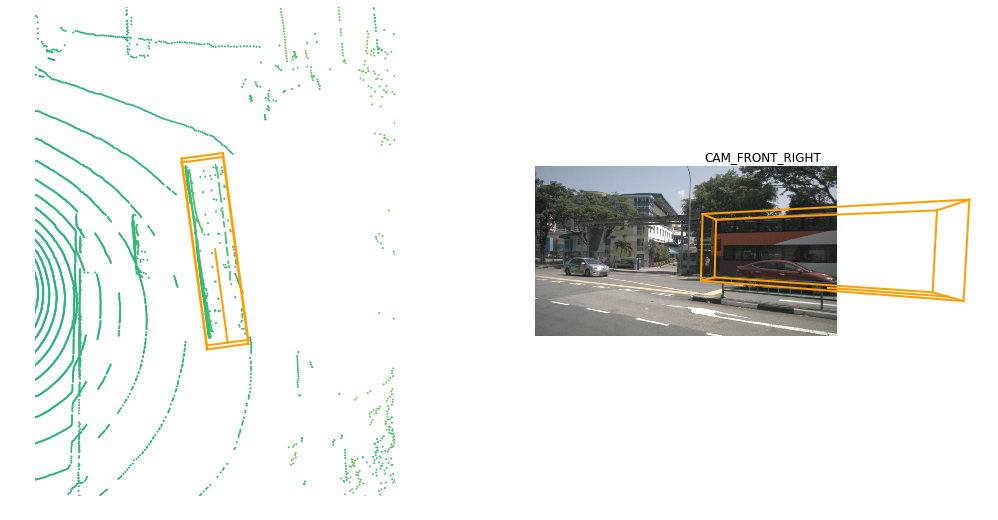

In [16]:
instance_token = my_instance['token']
nusc.render_instance(instance_token)

An instance record takes note of its first and last annotation token. Let's render them

First annotated sample of this instance:


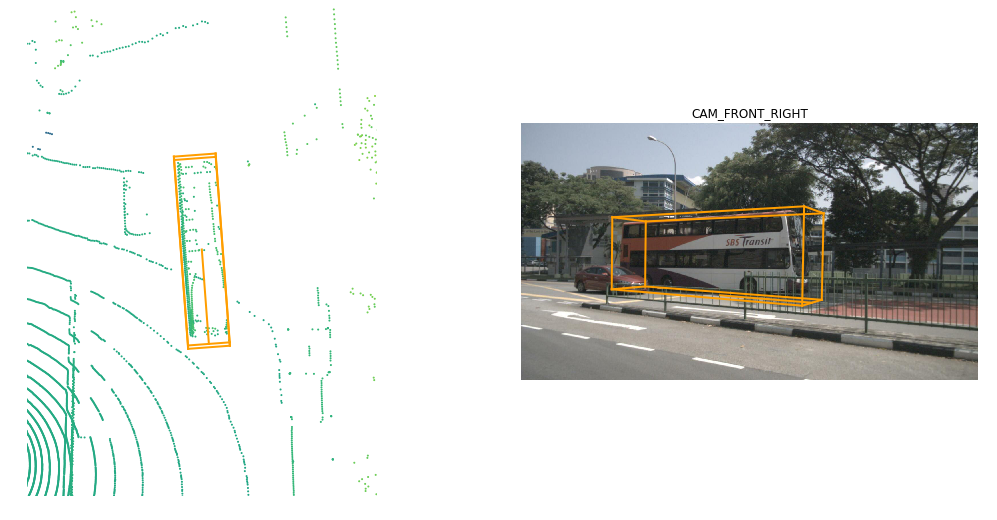

In [17]:
print("First annotated sample of this instance:")
nusc.render_annotation(my_instance['first_annotation_token'])

Last annotated sample of this instance


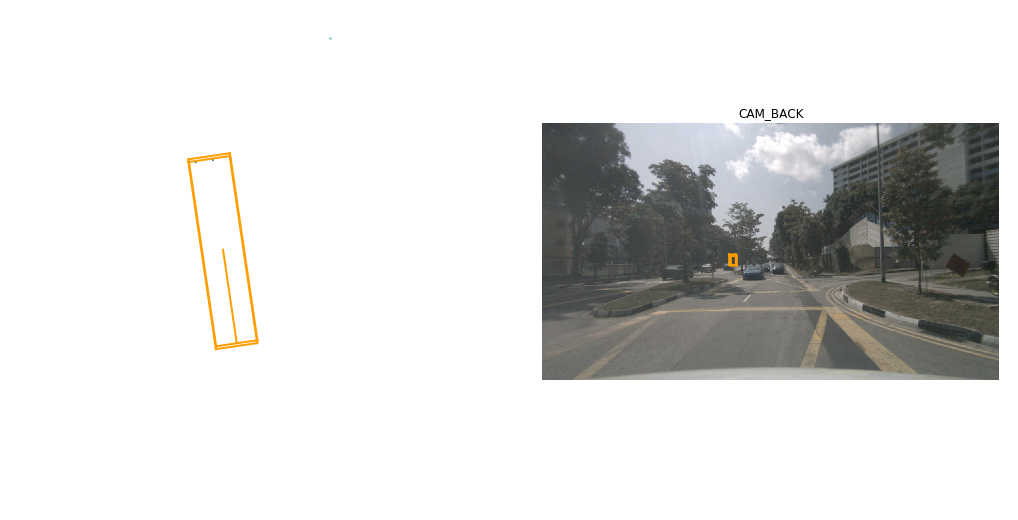

In [18]:
print("Last annotated sample of this instance")
nusc.render_annotation(my_instance['last_annotation_token'])

### 6. `category`

A `category` is the object assignment of an annotation.  Let's look at the category table we have in our database. The table contains the taxonomy of different object categories and also list the subcategories (delineated by a period). 

In [145]:
nusc.list_categories()

Category stats for split v1.0-mini:
human.pedestrian.adult      n= 4765, width= 0.68±0.11, len= 0.73±0.17, height= 1.76±0.12, lw_aspect= 1.08±0.23
human.pedestrian.child      n=   46, width= 0.46±0.08, len= 0.45±0.09, height= 1.37±0.06, lw_aspect= 0.97±0.05
human.pedestrian.constructi n=  193, width= 0.69±0.07, len= 0.74±0.12, height= 1.78±0.05, lw_aspect= 1.07±0.16
human.pedestrian.personal_m n=   25, width= 0.83±0.00, len= 1.28±0.00, height= 1.87±0.00, lw_aspect= 1.55±0.00
human.pedestrian.police_off n=   11, width= 0.59±0.00, len= 0.47±0.00, height= 1.81±0.00, lw_aspect= 0.80±0.00
movable_object.barrier      n= 2323, width= 2.32±0.49, len= 0.61±0.11, height= 1.06±0.10, lw_aspect= 0.28±0.09
movable_object.debris       n=   13, width= 0.43±0.00, len= 1.43±0.00, height= 0.46±0.00, lw_aspect= 3.35±0.00
movable_object.pushable_pul n=   82, width= 0.51±0.06, len= 0.79±0.10, height= 1.04±0.20, lw_aspect= 1.55±0.18
movable_object.trafficcone  n= 1378, width= 0.47±0.14, len= 0.45±0.07, heigh

A category record contains the name and the description of that particular category.

In [171]:
meters_to_feet = 3.28084

def category_stats_feet():
    """ Print categories, counts and stats. These stats only cover the split specified in nusc.version. 
    """
    print('Category stats for split %s:' % nusc.version)

    # Add all annotations
    categories = dict()
    for record in nusc.sample_annotation:
        if record['category_name'] not in categories:
            categories[record['category_name']] = []
        categories[record['category_name']].append(record['size'] + [record['size'][1] / record['size'][0]])

    # Print stats
    summaries = dict()
    for name, stats in sorted(categories.items()):
        stats = np.array(stats)
        width_avg = np.mean(stats[:, 0])*meters_to_feet # width
        length_avg = np.mean(stats[:, 1])*meters_to_feet # length
        height_avg = np.mean(stats[:, 2])*meters_to_feet # height
        # lw_aspect is the 4th entry
        
        summaries[name] = [width_avg, length_avg, height_avg]
    return summaries

stats = category_stats_feet()

def parse_category(summaries):
    for name in summaries:
        parts = name.split(".")
        # last part is the actual name
        # the parts before it are the descriptor
parse_category(stats)

Category stats for split v1.0-mini:


Refer to `instructions.md` for the definitions of the different categories.

### 7. `attribute`

An `attribute` is a property of an instance that may change throughout different parts of a scene while the category remains the same. Here we list the provided attributes and the number of annotations associated with a particular attribute.

In [21]:
nusc.list_attributes()

cycle.with_rider: 305
cycle.without_rider: 434
pedestrian.moving: 3875
pedestrian.sitting_lying_down: 111
pedestrian.standing: 1029
vehicle.moving: 2715
vehicle.parked: 4674
vehicle.stopped: 1545


Let's take a look at an example how an attribute may change over one scene

In [22]:
my_instance = nusc.instance[27]
first_token = my_instance['first_annotation_token']
last_token = my_instance['last_annotation_token']
nbr_samples = my_instance['nbr_annotations']
current_token = first_token

i = 0
found_change = False
while current_token != last_token:
    current_ann = nusc.get('sample_annotation', current_token)
    current_attr = nusc.get('attribute', current_ann['attribute_tokens'][0])['name']
    
    if i == 0:
        pass
    elif current_attr != last_attr:
        print("Changed from `{}` to `{}` at timestamp {} out of {} annotated timestamps".format(last_attr, current_attr, i, nbr_samples))
        found_change = True

    next_token = current_ann['next']
    current_token = next_token
    last_attr = current_attr
    i += 1

Changed from `pedestrian.moving` to `pedestrian.standing` at timestamp 21 out of 39 annotated timestamps


### 8. `visibility`

`visibility` is defined as the fraction of pixels of a particular annotation that are visible over the 6 camera feeds, grouped into 4 bins.

In [23]:
nusc.visibility

[{'description': 'visibility of whole object is between 0 and 40%',
  'token': '1',
  'level': 'v0-40'},
 {'description': 'visibility of whole object is between 40 and 60%',
  'token': '2',
  'level': 'v40-60'},
 {'description': 'visibility of whole object is between 60 and 80%',
  'token': '3',
  'level': 'v60-80'},
 {'description': 'visibility of whole object is between 80 and 100%',
  'token': '4',
  'level': 'v80-100'}]

Let's look at an example `sample_annotation` with 80-100% visibility

Visibility: {'description': 'visibility of whole object is between 80 and 100%', 'token': '4', 'level': 'v80-100'}


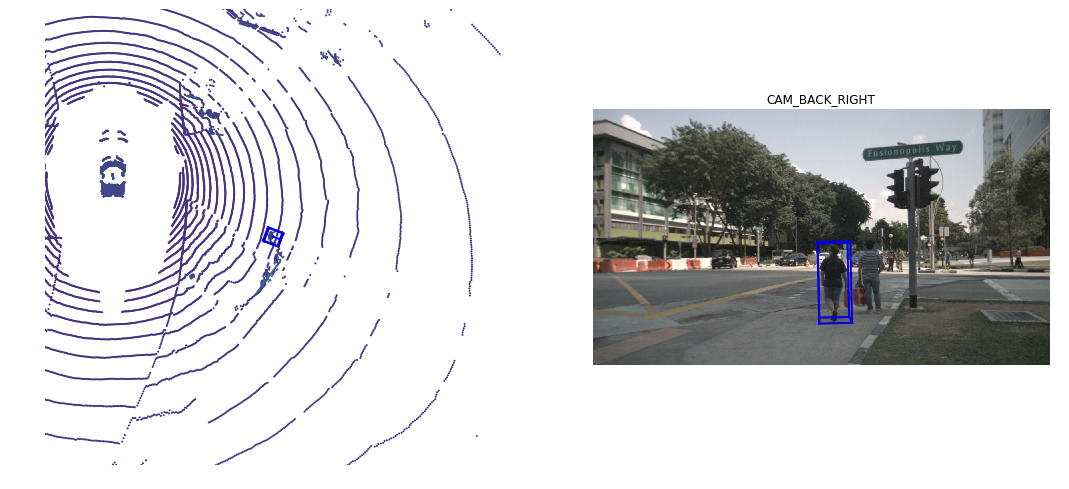

In [24]:
anntoken = 'a7d0722bce164f88adf03ada491ea0ba'
visibility_token = nusc.get('sample_annotation', anntoken)['visibility_token']

print("Visibility: {}".format(nusc.get('visibility', visibility_token)))
nusc.render_annotation(anntoken)

Let's look at an example `sample_annotation` with 0-40% visibility

Visibility: {'description': 'visibility of whole object is between 0 and 40%', 'token': '1', 'level': 'v0-40'}


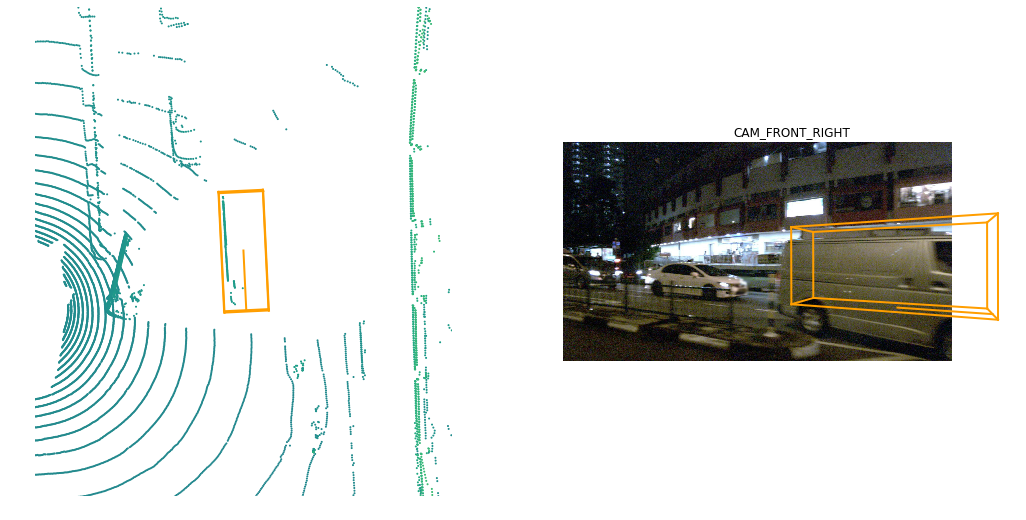

In [25]:
anntoken = '9f450bf6b7454551bbbc9a4c6e74ef2e'
visibility_token = nusc.get('sample_annotation', anntoken)['visibility_token']

print("Visibility: {}".format(nusc.get('visibility', visibility_token)))
nusc.render_annotation(anntoken)

### 9. `sensor`

The nuScenes dataset consists of data collected from our full sensor suite which consists of:
- 1 x LIDAR, 
- 5 x RADAR, 
- 6 x cameras, 

In [26]:
nusc.sensor

[{'token': '725903f5b62f56118f4094b46a4470d8',
  'channel': 'CAM_FRONT',
  'modality': 'camera'},
 {'token': 'ce89d4f3050b5892b33b3d328c5e82a3',
  'channel': 'CAM_BACK',
  'modality': 'camera'},
 {'token': 'a89643a5de885c6486df2232dc954da2',
  'channel': 'CAM_BACK_LEFT',
  'modality': 'camera'},
 {'token': 'ec4b5d41840a509984f7ec36419d4c09',
  'channel': 'CAM_FRONT_LEFT',
  'modality': 'camera'},
 {'token': '2f7ad058f1ac5557bf321c7543758f43',
  'channel': 'CAM_FRONT_RIGHT',
  'modality': 'camera'},
 {'token': 'ca7dba2ec9f95951bbe67246f7f2c3f7',
  'channel': 'CAM_BACK_RIGHT',
  'modality': 'camera'},
 {'token': 'dc8b396651c05aedbb9cdaae573bb567',
  'channel': 'LIDAR_TOP',
  'modality': 'lidar'},
 {'token': '47fcd48f71d75e0da5c8c1704a9bfe0a',
  'channel': 'RADAR_FRONT',
  'modality': 'radar'},
 {'token': '232a6c4dc628532e81de1c57120876e9',
  'channel': 'RADAR_FRONT_RIGHT',
  'modality': 'radar'},
 {'token': '1f69f87a4e175e5ba1d03e2e6d9bcd27',
  'channel': 'RADAR_FRONT_LEFT',
  'modality'

Every `sample_data` has a record on which `sensor` the data is collected from (note the "channel" key)

In [27]:
nusc.sample_data[10]

{'token': '2ecfec536d984fb491098c9db1404117',
 'sample_token': '356d81f38dd9473ba590f39e266f54e5',
 'ego_pose_token': '2ecfec536d984fb491098c9db1404117',
 'calibrated_sensor_token': 'f4d2a6c281f34a7eb8bb033d82321f79',
 'timestamp': 1532402928269133,
 'fileformat': 'pcd',
 'is_key_frame': False,
 'height': 0,
 'width': 0,
 'filename': 'sweeps/RADAR_FRONT/n015-2018-07-24-11-22-45+0800__RADAR_FRONT__1532402928269133.pcd',
 'prev': 'b933bbcb4ee84a7eae16e567301e1df2',
 'next': '79ef24d1eba84f5abaeaf76655ef1036',
 'sensor_modality': 'radar',
 'channel': 'RADAR_FRONT'}

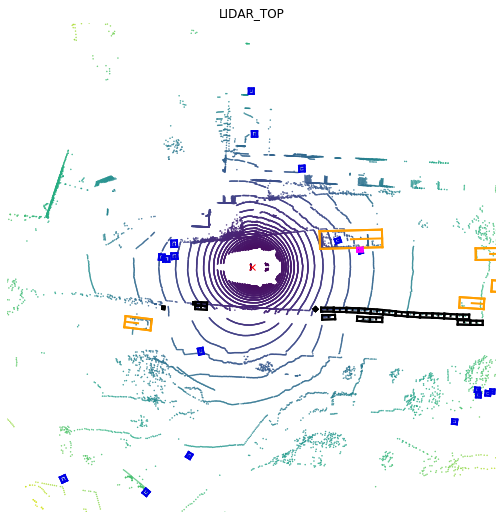

In [77]:
def display_lidar_sample(sample, sweeps=5):
    nusc.render_sample_data(sample['data']['LIDAR_TOP'], nsweeps=1,
                            underlay_map=False)
display_lidar_sample(first_sample, 1)

def get_lidar_points(sample):
    lidar_data = nusc.get('sample_data', sample['data']['LIDAR_TOP'])
    file_path = nuscenes_root+data_name+'/'+lidar_data['filename']
    points = LidarPointCloud.from_file(file_path)
    return points

### 10. `calibrated_sensor`

`calibrated_sensor` consists of the definition of a particular sensor (lidar/radar/camera) as calibrated on a particular vehicle. Let us look at an example.

In [28]:
nusc.calibrated_sensor[0]

{'token': 'f4d2a6c281f34a7eb8bb033d82321f79',
 'sensor_token': '47fcd48f71d75e0da5c8c1704a9bfe0a',
 'translation': [3.412, 0.0, 0.5],
 'rotation': [0.9999984769132877, 0.0, 0.0, 0.0017453283658983088],
 'camera_intrinsic': []}

Note that the `translation` and the `rotation` parameters are given with respect to the ego vehicle body frame. 

### 11. `ego_pose`

`ego_pose` contains information about the location (encoded in `translation`) and the orientation (encoded in `rotation`) of the ego vehicle body frame, with respect to the global coordinate system.

In [29]:
nusc.ego_pose[0]

{'token': '5ace90b379af485b9dcb1584b01e7212',
 'timestamp': 1532402927814384,
 'rotation': [0.5731787718287827,
  -0.0015811634307974854,
  0.013859363182046986,
  -0.8193116095230444],
 'translation': [410.77878632230204, 1179.4673290964536, 0.0]}

Note that the number of `ego_pose` records in our loaded database is the same as the number of `sample_data` records. These two records exhibit a one-to-one correspondence.

### 12. `log`

The `log` table contains log information from which the data was extracted. A `log` record corresponds to one journey of our ego vehicle along a predefined route. Let's check the number of logs and the metadata of a log.

In [30]:
print("Number of `logs` in our loaded database: {}".format(len(nusc.log)))

Number of `logs` in our loaded database: 8


In [31]:
nusc.log[0]

{'token': '7e25a2c8ea1f41c5b0da1e69ecfa71a2',
 'logfile': 'n015-2018-07-24-11-22-45+0800',
 'vehicle': 'n015',
 'date_captured': '2018-07-24',
 'location': 'singapore-onenorth',
 'map_token': '53992ee3023e5494b90c316c183be829'}

Notice that it contains a variety of information such as the date and location of the log collected. It also gives out information about the map from where the data was collected. Note that one log can contain multiple non-overlapping scenes.

### 13. `map`

Map information is stored as binary semantic masks from a top-down view. Let's check the number of maps and metadata of a map.

In [32]:
print("There are {} maps masks in the loaded dataset".format(len(nusc.map)))

There are 4 maps masks in the loaded dataset


In [33]:
nusc.map[0]

{'category': 'semantic_prior',
 'token': '53992ee3023e5494b90c316c183be829',
 'filename': 'maps/53992ee3023e5494b90c316c183be829.png',
 'log_tokens': ['0986cb758b1d43fdaa051ab23d45582b',
  '1c9b302455ff44a9a290c372b31aa3ce',
  'e60234ec7c324789ac7c8441a5e49731',
  '46123a03f41e4657adc82ed9ddbe0ba2',
  'a5bb7f9dd1884f1ea0de299caefe7ef4',
  'bc41a49366734ebf978d6a71981537dc',
  'f8699afb7a2247e38549e4d250b4581b',
  'd0450edaed4a46f898403f45fa9e5f0d',
  'f38ef5a1e9c941aabb2155768670b92a',
  '7e25a2c8ea1f41c5b0da1e69ecfa71a2',
  'ddc03471df3e4c9bb9663629a4097743',
  '31e9939f05c1485b88a8f68ad2cf9fa4',
  '783683d957054175bda1b326453a13f4',
  '343d984344e440c7952d1e403b572b2a',
  '92af2609d31445e5a71b2d895376fed6',
  '47620afea3c443f6a761e885273cb531',
  'd31dc715d1c34b99bd5afb0e3aea26ed',
  '34d0574ea8f340179c82162c6ac069bc',
  'd7fd2bb9696d43af901326664e42340b',
  'b5622d4dcb0d4549b813b3ffb96fbdc9',
  'da04ae0b72024818a6219d8dd138ea4b',
  '6b6513e6c8384cec88775cae30b78c0e',
  'eda311bda86f

## nuScenes Basics

Let's get a bit technical.

The NuScenes class holds several tables. Each table is a list of records, and each record is a dictionary. For example the first record of the category table is stored at:

In [34]:
nusc.category[0]

{'token': '1fa93b757fc74fb197cdd60001ad8abf',
 'name': 'human.pedestrian.adult',
 'description': 'Adult subcategory.'}

The category table is simple: it holds the fields `name` and `description`. It also has a `token` field, which is a unique record identifier. Since the record is a dictionary, the token can be accessed like so:

In [35]:
cat_token = nusc.category[0]['token']
cat_token

'1fa93b757fc74fb197cdd60001ad8abf'

If you know the `token` for any record in the DB you can retrieve the record by doing

In [36]:
nusc.get('category', cat_token)

{'token': '1fa93b757fc74fb197cdd60001ad8abf',
 'name': 'human.pedestrian.adult',
 'description': 'Adult subcategory.'}

_As you can notice, we have recovered the same record!_

OK, that was easy. Let's try something harder. Let's look at the `sample_annotation` table.

In [37]:
nusc.sample_annotation[0]

{'token': '70aecbe9b64f4722ab3c230391a3beb8',
 'sample_token': 'cd21dbfc3bd749c7b10a5c42562e0c42',
 'instance_token': '6dd2cbf4c24b4caeb625035869bca7b5',
 'visibility_token': '4',
 'attribute_tokens': ['4d8821270b4a47e3a8a300cbec48188e'],
 'translation': [373.214, 1130.48, 1.25],
 'size': [0.621, 0.669, 1.642],
 'rotation': [0.9831098797903927, 0.0, 0.0, -0.18301629506281616],
 'prev': 'a1721876c0944cdd92ebc3c75d55d693',
 'next': '1e8e35d365a441a18dd5503a0ee1c208',
 'num_lidar_pts': 5,
 'num_radar_pts': 0,
 'category_name': 'human.pedestrian.adult'}

This also has a `token` field (they all do). In addition, it has several fields of the format [a-z]*\_token, _e.g._ instance_token. These are foreign keys in database terminology, meaning they point to another table. 
Using `nusc.get()` we can grab any of these in constant time. For example, let's look at the visibility record.

In [38]:
nusc.get('visibility', nusc.sample_annotation[0]['visibility_token'])

{'description': 'visibility of whole object is between 80 and 100%',
 'token': '4',
 'level': 'v80-100'}

The visibility records indicate how much of an object was visible when it was annotated.

Let's also grab the `instance_token`

In [39]:
one_instance = nusc.get('instance', nusc.sample_annotation[0]['instance_token'])
one_instance

{'token': '6dd2cbf4c24b4caeb625035869bca7b5',
 'category_token': '1fa93b757fc74fb197cdd60001ad8abf',
 'nbr_annotations': 39,
 'first_annotation_token': 'ef63a697930c4b20a6b9791f423351da',
 'last_annotation_token': '8bb63134d48840aaa2993f490855ff0d'}

This points to the `instance` table. This table enumerate the object _instances_ we have encountered in each 
scene. This way we can connect all annotations of a particular object.

If you look carefully at the README tables, you will see that the sample_annotation table points to the instance table, 
but the instance table doesn't list all annotations that point to it. 

So how can we recover all sample_annotations for a particular object instance? There are two ways:

1. `Use nusc.field2token()`. Let's try it:

In [40]:
ann_tokens = nusc.field2token('sample_annotation', 'instance_token', one_instance['token'])

This returns a list of all sample_annotation records with the `'instance_token'` == `one_instance['token']`. Let's store these in a set for now

In [41]:
ann_tokens_field2token = set(ann_tokens)

ann_tokens_field2token

{'05e0ad1194804f548be544f2267c7e74',
 '060be69422ee4b2a8b239b463b995e92',
 '146b2111cc0c401ca09d96777758d81e',
 '163d85048698495dbf55a35f613c5fb9',
 '17a6843fefcd4b2b811eddbb1ccd708d',
 '1de9ad564050444486eb587360cf135f',
 '1e8e35d365a441a18dd5503a0ee1c208',
 '23f10d5f0d254068941be8797493c7eb',
 '2b5948828cdb49e3be6be1320381bbbf',
 '3a930d1793434d9a8a87d6eba28ff70e',
 '3b24f083c0bf42d695a1040efdab7ffe',
 '4e41d9560dbf46cab1568b8ef6a282f3',
 '6f371d3f0d7d494eaa6f81daa3df58c0',
 '70aecbe9b64f4722ab3c230391a3beb8',
 '74f550e3257c4f52af1102c0d49d37b8',
 '7670ac8bc5044d5a9e11e205c839385d',
 '794fcc425f074a1392206ed925fdbbd8',
 '7987617983634b119e383d8a29607fd7',
 '7fa3a688931b4500b7ce29d187d3b975',
 '807b3e029a6b4e428f6cc82fc26a35a7',
 '8bb63134d48840aaa2993f490855ff0d',
 '90d94112b9ea4fb691e988b40af5b161',
 '913072e56d6c4025b9b47ba085dd6d7c',
 '93d5b79041c64693a5b32f1103a39a06',
 '9acb7dfed3454f72b2874dda3bdacc48',
 'a1721876c0944cdd92ebc3c75d55d693',
 'a2b20cdbf1ed4018ac795b8845d5deaa',
 

The `nusc.field2token()` method is generic and can be used in any similar situation.

2. For certain situation, we provide some reverse indices in the tables themselves. This is one such example. 

The instance record has a field `first_annotation_token` which points to the first annotation in time of this instance. 
Recovering this record is easy.

In [42]:
ann_record = nusc.get('sample_annotation', one_instance['first_annotation_token'])
ann_record

{'token': 'ef63a697930c4b20a6b9791f423351da',
 'sample_token': 'ca9a282c9e77460f8360f564131a8af5',
 'instance_token': '6dd2cbf4c24b4caeb625035869bca7b5',
 'visibility_token': '1',
 'attribute_tokens': ['4d8821270b4a47e3a8a300cbec48188e'],
 'translation': [373.256, 1130.419, 0.8],
 'size': [0.621, 0.669, 1.642],
 'rotation': [0.9831098797903927, 0.0, 0.0, -0.18301629506281616],
 'prev': '',
 'next': '7987617983634b119e383d8a29607fd7',
 'num_lidar_pts': 1,
 'num_radar_pts': 0,
 'category_name': 'human.pedestrian.adult'}

Now we can traverse all annotations of this instance using the "next" field. Let's try it. 

In [43]:
ann_tokens_traverse = set()
ann_tokens_traverse.add(ann_record['token'])
while not ann_record['next'] == "":
    ann_record = nusc.get('sample_annotation', ann_record['next'])
    ann_tokens_traverse.add(ann_record['token'])

Finally, let's assert that we recovered the same ann_records as we did using nusc.field2token:

In [44]:
print(ann_tokens_traverse == ann_tokens_field2token)

True


## Reverse indexing and short-cuts

The nuScenes tables are normalized, meaning that each piece of information is only given once.
For example, there is one `map` record for each `log` record. Looking at the schema you will notice that the `map` table has a `log_token` field, but that the `log` table does not have a corresponding `map_token` field. But there are plenty of situations where you have a `log`, and want to find the corresponding `map`! So what to do? You can always use the `nusc.field2token()` method, but that is slow and inconvenient. We therefore add reverse mappings for some common situations including this one.

Further, there are situations where one needs to go through several tables to get a certain piece of information. 
Consider, for example, the category name (e.g. `human.pedestrian`) of a `sample_annotation`. The `sample_annotation` table doesn't hold this information since the category is an instance level constant. Instead the `sample_annotation` table points to a record in the `instance` table. This, in turn, points to a record in the `category` table, where finally the `name` fields stores the required information.

Since it is quite common to want to know the category name of an annotation, we add a `category_name` field to the `sample_annotation` table during initialization of the NuScenes class.

In this section, we list the short-cuts and reverse indices that are added to the `NuScenes` class during initialization. These are all created in the `NuScenes.__make_reverse_index__()` method.

### Reverse indices
We add two reverse indices by default.
* A `map_token` field is added to the `log` records.
* The `sample` records have shortcuts to all `sample_annotations` for that record as well as `sample_data` key-frames. Confer `nusc.list_sample()` method in the previous section for more details on this.

### Shortcuts

The sample_annotation table has a "category_name" shortcut.

_Using shortcut:_

In [45]:
catname = nusc.sample_annotation[0]['category_name']

_Not using shortcut:_

In [46]:
ann_rec = nusc.sample_annotation[0]
inst_rec = nusc.get('instance', ann_rec['instance_token'])
cat_rec = nusc.get('category', inst_rec['category_token'])

print(catname == cat_rec['name'])

True


The sample_data table has "channel" and "sensor_modality" shortcuts:

In [47]:
# Shortcut
channel = nusc.sample_data[0]['channel']

# No shortcut
sd_rec = nusc.sample_data[0]
cs_record = nusc.get('calibrated_sensor', sd_rec['calibrated_sensor_token'])
sensor_record = nusc.get('sensor', cs_record['sensor_token'])

print(channel == sensor_record['channel'])

True


## Data Visualizations

We provide list and rendering methods. These are meant both as convenience methods during development, and as tutorials for building your own visualization methods. They are implemented in the NuScenesExplorer class, with shortcuts through the NuScenes class itself.

### List methods
There are three list methods available.

1. `list_categories()` lists all categories, counts and statistics of width/length/height in meters and aspect ratio.

In [48]:
nusc.list_categories()

Category stats for split v1.0-mini:
human.pedestrian.adult      n= 4765, width= 0.68±0.11, len= 0.73±0.17, height= 1.76±0.12, lw_aspect= 1.08±0.23
human.pedestrian.child      n=   46, width= 0.46±0.08, len= 0.45±0.09, height= 1.37±0.06, lw_aspect= 0.97±0.05
human.pedestrian.constructi n=  193, width= 0.69±0.07, len= 0.74±0.12, height= 1.78±0.05, lw_aspect= 1.07±0.16
human.pedestrian.personal_m n=   25, width= 0.83±0.00, len= 1.28±0.00, height= 1.87±0.00, lw_aspect= 1.55±0.00
human.pedestrian.police_off n=   11, width= 0.59±0.00, len= 0.47±0.00, height= 1.81±0.00, lw_aspect= 0.80±0.00
movable_object.barrier      n= 2323, width= 2.32±0.49, len= 0.61±0.11, height= 1.06±0.10, lw_aspect= 0.28±0.09
movable_object.debris       n=   13, width= 0.43±0.00, len= 1.43±0.00, height= 0.46±0.00, lw_aspect= 3.35±0.00
movable_object.pushable_pul n=   82, width= 0.51±0.06, len= 0.79±0.10, height= 1.04±0.20, lw_aspect= 1.55±0.18
movable_object.trafficcone  n= 1378, width= 0.47±0.14, len= 0.45±0.07, heigh

2. `list_attributes()` lists all attributes and counts.

In [49]:
nusc.list_attributes()

cycle.with_rider: 305
cycle.without_rider: 434
pedestrian.moving: 3875
pedestrian.sitting_lying_down: 111
pedestrian.standing: 1029
vehicle.moving: 2715
vehicle.parked: 4674
vehicle.stopped: 1545


3. `list_scenes()` lists all scenes in the loaded DB.

In [50]:
nusc.list_scenes()

scene-0061, Parked truck, construction, intersectio... [18-07-24 03:28:47]   19s, singapore-onenorth, #anns:4622
scene-0103, Many peds right, wait for turning car, ... [18-08-01 19:26:43]   19s, boston-seaport, #anns:2046
scene-0655, Parking lot, parked cars, jaywalker, be... [18-08-27 15:51:32]   20s, boston-seaport, #anns:2332
scene-0553, Wait at intersection, bicycle, large tr... [18-08-28 20:48:16]   20s, boston-seaport, #anns:1950
scene-0757, Arrive at busy intersection, bus, wait ... [18-08-30 19:25:08]   20s, boston-seaport, #anns:592
scene-0796, Scooter, peds on sidewalk, bus, cars, t... [18-10-02 02:52:24]   20s, singapore-queensto, #anns:708
scene-0916, Parking lot, bicycle rack, parked bicyc... [18-10-08 07:37:13]   20s, singapore-queensto, #anns:2387
scene-1077, Night, big street, bus stop, high speed... [18-11-21 11:39:27]   20s, singapore-hollandv, #anns:890
scene-1094, Night, after rain, many peds, PMD, ped ... [18-11-21 11:47:27]   19s, singapore-hollandv, #anns:1762
sc

### Render

First, let's plot a lidar point cloud in an image. Lidar allows us to accurately map the surroundings in 3D.

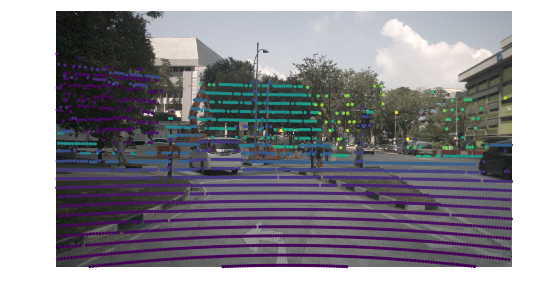

In [51]:
my_sample = nusc.sample[10]
nusc.render_pointcloud_in_image(my_sample['token'], pointsensor_channel='LIDAR_TOP')

In the previous image the colors indicate the distance from the ego vehicle to each lidar point. We can also render the lidar intensity. In the following image the traffic sign ahead of us is highly reflective (yellow) and the dark vehicle on the right has low reflectivity (purple).

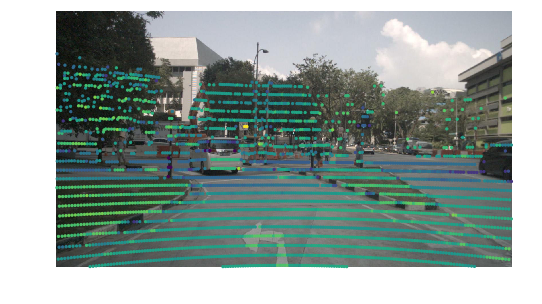

In [52]:
nusc.render_pointcloud_in_image(my_sample['token'], pointsensor_channel='LIDAR_TOP', render_intensity=True)

Second, let's plot the radar point cloud for the same image. Radar is less dense than lidar, but has a much larger range.

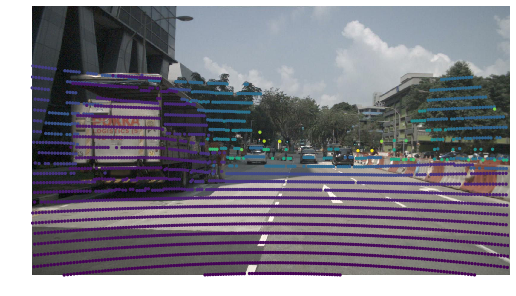

In [80]:
nusc.render_pointcloud_in_image(my_sample['token'], pointsensor_channel='LIDAR_TOP')

We can also plot all annotations across all sample data for that sample. Note how for radar we also plot the velocity vectors of moving objects. Some velocity vectors are outliers, which can be filtered using the settings in RadarPointCloud.from_file()

In [43]:
my_sample = nusc.sample[20]

# The rendering command below is commented out because it may crash in notebooks
# nusc.render_sample(my_sample['token'])

Or if we only want to render a particular sensor, we can specify that.

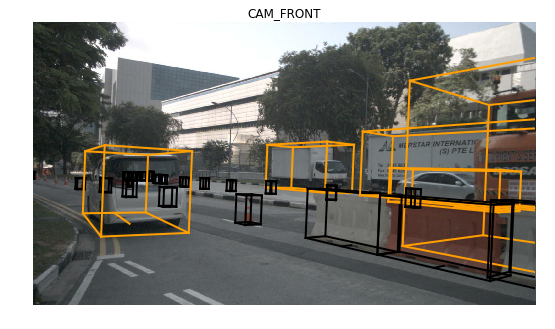

In [55]:
nusc.render_sample_data(my_sample['data']['CAM_FRONT'])

Additionally we can aggregate the point clouds from multiple sweeps to get a denser point cloud.

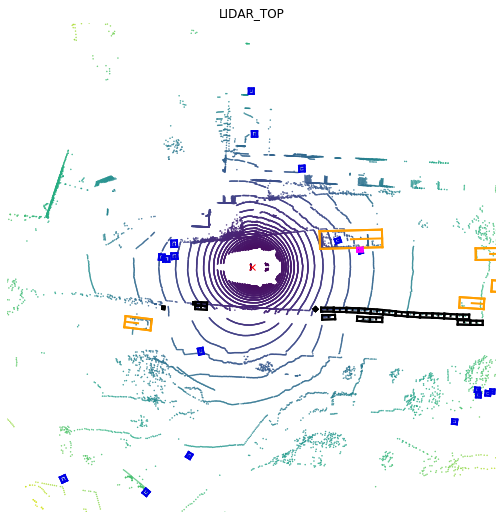

In [73]:
nusc.render_sample_data(first_sample['data']['LIDAR_TOP'], nsweeps=5, underlay_map=False)
#nusc.render_sample_data(my_sample['data']['RADAR_FRONT_RIGHT'], nsweeps=5, underlay_map=True)

We can even render a specific annotation.

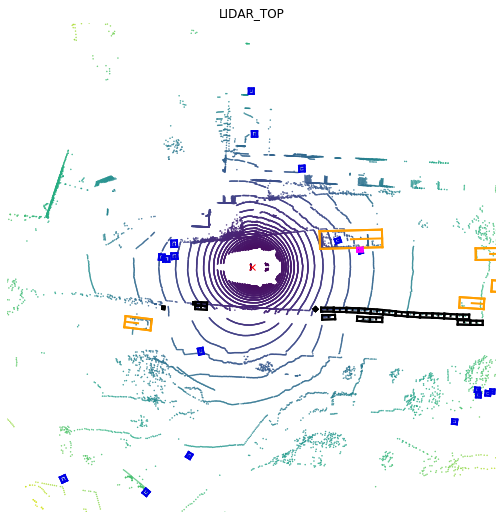

In [27]:
def nuscenes_test(sweeps=5):
    lidar_data = nusc.get('sample_data', my_sample['data']['LIDAR_TOP'])
    #pp.pprint(lidar_data['calibrated_sensor_token'])
    file_path = nuscenes_root+data_name+'/'+lidar_data['filename']
    points = LidarPointCloud.from_file(file_path)
   # pp.pprint(points.points)
#    pc.render_intensity()
    nusc.render_sample_data(my_sample['data']['LIDAR_TOP'], nsweeps=1,
                            underlay_map=False)
nuscenes_test(1)

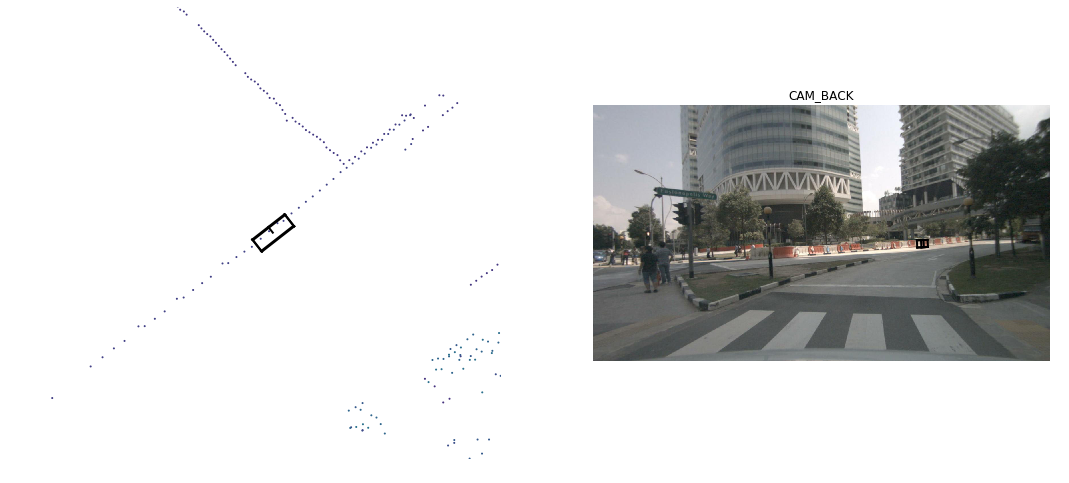

In [44]:
nusc.render_annotation(my_sample['anns'][22])